alfie pymongo use

In [1]:
import os
from dotenv import load_dotenv
from pathlib import Path
from pymongo import MongoClient
import matplotlib.pyplot as plt
import pandas as pd
import ast
import datetime
import seaborn as sns
import json
import numpy as np

import matplotlib as mpl

from datetime import datetime
from dateutil.parser import parse

#need to translate from wgs to bng to do spatial clustering
import pyproj

from pandas.io.json import json_normalize

#now to try out the clustering with this new data set
#now import DBSCAN clustering package
from sklearn.cluster import DBSCAN

In [2]:
# specifies number of rows to show
pd.set_option('display.max_rows', 300) 

# specifies default number format to 4 decimal places
pd.options.display.float_format = '{:40,.4f}'.format 

# specifies that graphs should use ggplot styling
plt.style.use('ggplot') 

%matplotlib inline

## Some setups

In [3]:
pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
%matplotlib inline

In [4]:
from astropy.stats import RipleysKEstimator

In [5]:
# load .env variable
# base_dir = 'D:\Documentos\GitHub\CityBlender'
# dotenv_file = os.path.join(base_dir, '.env')

base_dir = 'C:/Users/Alfie/Documents/MSc Smart Cities/Term 2/Spatial Data Capture Storage and Analysis/Coursework/Analysis Test/'
dotenv_file = os.path.join(base_dir, '.env')


# Continue loading stuff

if os.path.isfile(dotenv_file):
    load_dotenv(dotenv_file, verbose=True)
    
db_uri = os.getenv('DB_URI')

db_client = MongoClient(str(db_uri))


# choose a database to connect to (.london)
db_london = db_client.london
status = db_client.london.command('serverStatus')


# create the connections and build the local datasets
db_london_events = db_london['events']
db_london_artist = db_london['artists']

allLondonEvents = db_london_events.find()

londonEventsdf = pd.DataFrame(list(allLondonEvents))

C:\Users\Alfie\Anaconda3\lib\site-packages\pymongo\common.py:555: UserWarning: Unknown option retryWrites
  warnings.warn(str(exc))


# Some processing

In [6]:
# Put this in the date format
londonEventsdf['date'] = [(datetime.strptime(londonEventsdf['date'][x], '%Y-%m-%d')) for x in range(len(londonEventsdf['date']))]

# Convert the dates into day name
londonEventsdf['date_name'] = [(londonEventsdf['date'][x].strftime("%A")) for x in range(len(londonEventsdf['date']))]

# Lat & Long
londonEventsdf['lat'] = [(londonEventsdf['location'][x]['lat']) for x in range(len(londonEventsdf['location']))]
londonEventsdf['lng'] = [(londonEventsdf['location'][x]['lng']) for x in range(len(londonEventsdf['location']))]

# Dates in the dataset

In [7]:
#get min and max date of this dataset
print(min(londonEventsdf['date']))
print(max((londonEventsdf['date'])))

2018-04-13 00:00:00
2018-05-27 00:00:00


In [8]:
# Define some common projections using EPSG codes
wgs84=pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
osgb36=pyproj.Proj("+init=EPSG:27700") # UK Ordnance Survey, 1936 datum

In [9]:
#create a new pd without NaNs
londonEventsdfNoNan = londonEventsdf[londonEventsdf['lat'].notnull()]

#make new columns for the new latlng
londonEventsdfNoNan['BNGnorthing'] = ""
londonEventsdfNoNan['BNGeasting'] = ""


londonEventsdfNoNan = londonEventsdfNoNan.reset_index()

C:\Users\Alfie\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Alfie\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
#now run through the dataset and transform those coordinates
origLat = []
origLng = []

for i in londonEventsdfNoNan['index']:
    # print(i)
    try:
        origLat.append(londonEventsdfNoNan['lat'][i])
        origLng.append(londonEventsdfNoNan['lng'][i])
        
    except:
        origLat.append(np.nan)
        origLng.append(np.nan)

In [11]:
lat,lon = pyproj.transform(wgs84,osgb36,origLat,origLng)
    
londonEventsdfNoNan['BNGnorthing'] = lat
londonEventsdfNoNan['BNGeasting'] = lon

In [12]:
londonEventsdfNoNan

,index,_id,artists,date,datetime,datetime_source,foursquare,id,lastfm,location,...,spotify,time,type,url,venue,date_name,lat,lng,BNGnorthing,BNGeasting
0,0,5af9c6dc0cc9ab0004e227d1,[{'mbid': ['aca5718f-4f49-4439-b8f6-209db3f117...,2018-05-14,2018-05-14 18:00:00,2018-05-14T19:00:00+0100,"{'id': '4ac518e9f964a520daab20e3', 'name': 'Ro...",31245569,"{'listeners': [412072, 57, 192843], 'listeners...","{'lng': -0.1491962, 'lat': 51.5429551}",...,"{'genres': [], 'popularity': [64, 25, 32], 'po...",19:00:00,Concert,http://www.songkick.com/concerts/31245569-fran...,"{'id': 17874, 'name': 'Roundhouse', 'location'...",Monday,51.5430,-0.1492,"7,471,890.3385","-5,555,678.2760"
1,1,5af9c6de0cc9ab0004e227d3,"[{'mbid': [], 'id': 8437833, 'name': 'Andy May...",2018-05-14,NaT,None,"{'id': '4ac518c5f964a520afa420e3', 'name': 'Th...",31640764,"{'listeners': [18], 'listeners_sum': 18, 'play...","{'lng': -0.1011681, 'lat': 51.5233496}",...,"{'genres': [], 'popularity': [3], 'popularity_...",None,Concert,http://www.songkick.com/concerts/31640764-andy...,"{'id': 6950, 'name': 'The Slaughtered Lamb', '...",Monday,51.5233,-0.1012,"7,468,300.3744","-5,546,750.6695"
2,2,5af9c6e30cc9ab0004e227d6,[{'mbid': ['6655955b-1c1e-4bcb-84e4-81bcd9efab...,2018-05-14,2018-05-14 17:45:00,2018-05-14T18:45:00+0100,"{'id': '4ac518e8f964a52075ab20e3', 'name': 'Ro...",31785344,"{'listeners': [721424, 19477], 'listeners_sum'...","{'lng': -0.1781517, 'lat': 51.500786}",...,"{'genres': ['bow pop', 'chamber pop', 'composi...",18:45:00,Concert,http://www.songkick.com/concerts/31785344-olaf...,"{'id': 17538, 'name': 'Royal Albert Hall', 'lo...",Monday,51.5008,-0.1782,"7,464,094.0449","-5,561,022.8424"
3,3,5af9c6e50cc9ab0004e227d8,[{'mbid': ['d100e4ac-31f1-4af1-b0e1-f07c545abb...,2018-05-14,2018-05-14 18:00:00,2018-05-14T19:00:00+0100,"{'id': '53713174498e54bcdede7275', 'name': 'Up...",32044684,"{'listeners': [313], 'listeners_sum': 313, 'pl...","{'lng': -0.1038429, 'lat': 51.5466983}",...,"{'genres': ['scottish folk'], 'popularity': [3...",19:00:00,Concert,http://www.songkick.com/concerts/32044684-elep...,"{'id': 434301, 'name': 'Thousand Island (forme...",Monday,51.5467,-0.1038,"7,472,605.8569","-5,547,257.8495"
4,4,5af9c6eb0cc9ab0004e227db,[{'mbid': ['366323f3-0409-4a30-a3e9-ce1e25d277...,2018-05-14,2018-05-14 18:30:00,2018-05-14T19:30:00+0100,"{'id': '4b5e0cfdf964a520037b29e3', 'name': 'Bu...",32192284,"{'listeners': [7057, 3625], 'listeners_sum': 1...","{'lng': -0.2314873, 'lat': 51.5062847}",...,"{'genres': [], 'popularity': [25, 1], 'popular...",19:30:00,Concert,http://www.songkick.com/concerts/32192284-gary...,"{'id': 17541, 'name': 'Bush Hall', 'location':...",Monday,51.5063,-0.2315,"7,465,060.8927","-5,570,923.1732"
5,5,5af9c6ed0cc9ab0004e227dd,[{'mbid': ['a1ef6bc8-2644-4b6d-aa21-27b630acf7...,2018-05-14,2018-05-14 18:30:00,2018-05-14T19:30:00+0100,{},32454499,"{'listeners': [113695], 'listeners_sum': 11369...","{'lng': -0.5541293, 'lat': 51.2486437}",...,"{'genres': ['pub rock', 'roots rock'], 'popula...",19:30:00,Concert,http://www.songkick.com/concerts/32454499-nils...,"{'id': 1262471, 'name': 'G Live', 'location': ...",Monday,51.2486,-0.5541,"7,417,168.1322","-5,630,182.8604"
6,6,5af9c6ef0cc9ab0004e227df,[{'mbid': ['c1982570-8efb-4cf7-bb5b-c9c026c0e8...,2018-05-14,2018-05-14 18:00:00,2018-05-14T19:00:00+0100,"{'id': '59bbad4dfebf314eba5d9fbb', 'name': 'Br...",32492684,"{'listeners': [120157], 'listeners_sum': 12015...","{'lng': -0.0774607, 'lat': 51.5033289}",...,"{'genres': ['afropop', 'world'], 'popularity':...",19:00:00,Concert,http://www.songkick.com/concerts/32492684-lady...,"{'id': 3565864, 'name': 'Bridge Theatre', 'loc...",Monday,51.5033,-0.0775,"7,464,618.5515","-5,542,343.1906"
7,7,5af9c6f00cc9ab0004e227e1,"[{'mbid': [], 'id': 6651674, 'name': 'Gemma Kh...",2018-05-14,2018-05-14 18:00:00,2018-05-14T19:00:00+0100,"{'id': '53aa2db3498e191dfd67bd05', 'name': 'Fo...",32649974,"{'listeners': [32], 'listeners_sum': 32, 'play...","{'lng': -0.1355174, 'lat': 51.5

In [13]:
londonEventsdfNoNan['BNGnorthing'] = pd.to_numeric(londonEventsdfNoNan['BNGnorthing'])
londonEventsdfNoNan['BNGeasting'] = pd.to_numeric(londonEventsdfNoNan['BNGeasting'])

In [14]:
minLatLdn = min(londonEventsdfNoNan['BNGnorthing'])
minLngLdn = min(londonEventsdfNoNan['BNGeasting'])
maxLatLdn = max(londonEventsdfNoNan['BNGnorthing'])
maxLngLdn = max(londonEventsdfNoNan['BNGeasting'])

In [15]:
londonEventsdfNoNan = londonEventsdfNoNan[londonEventsdfNoNan['BNGnorthing'].notnull()]

In [16]:
londonEventsdfNoNan = londonEventsdfNoNan.reset_index()

In [17]:
# Make a function to subset the genere depending on which dataset
def subset_by_genere(db = londonEventsdfNoNan, lib = 'spotify', words = 'reggae'):
    return db[db[lib].astype(str).str.contains(words, case=False)]

In [18]:
reggaeEventsdf = subset_by_genere()

reggaeEventsdf2 = subset_by_genere(lib = 'lastfm')
allReggaeEvents = pd.concat([reggaeEventsdf,reggaeEventsdf2])

In [19]:
#get rid of duplicates
allReggaeEvents = allReggaeEvents.drop_duplicates(subset='_id', keep='last')

In [20]:
allReggaeEvents

,level_0,index,_id,artists,date,datetime,datetime_source,foursquare,id,lastfm,...,spotify,time,type,url,venue,date_name,lat,lng,BNGnorthing,BNGeasting
14,14,14,5af9c7040cc9ab0004e227f2,[{'mbid': ['e3c24e1c-1e43-403b-8407-90c8c41070...,2018-05-14,2018-05-14 18:30:00,2018-05-14T19:30:00+0100,"{'id': '4b75c0dcf964a52020222ee3', 'name': 'Th...",33042619,"{'listeners': [162766, 9376, 15377], 'listener...",...,"{'genres': ['canadian hip hop', 'pop', 'rap', ...",19:30:00,Concert,http://www.songkick.com/concerts/33042619-now-...,"{'id': 29349, 'name': 'The Dome, Tufnell Park'...",Monday,51.5576,-0.1388,"7,474,597.0288","-5,553,750.6861"
82,82,82,5af9c7ca0cc9ab0004e22896,[{'mbid': ['51f447ee-e5ba-4cc1-b27c-42ea5a6103...,2018-05-15,2018-05-15 18:30:00,2018-05-15T19:30:00+0100,"{'id': '4b5e0cfdf964a520037b29e3', 'name': 'Bu...",33450909,"{'listeners': [39247, 36646], 'listeners_sum':...",...,"{'genres': ['pop', 'post-teen pop', 'teen pop'...",19:30:00,Concert,http://www.songkick.com/concerts/33450909-jack...,"{'id': 17541, 'name': 'Bush Hall', 'location':...",Tuesday,51.5063,-0.2315,"7,465,060.8927","-5,570,923.1732"
270,270,270,5afabb18dcab560004a0b08f,[{'mbid': ['83bde443-318c-4d4e-8f31-1ca159df14...,2018-05-18,2018-05-18 17:30:00,2018-05-18T18:30:00+0100,"{'id': '53713174498e54bcdede7275', 'name': 'Up...",32751419,"{'listeners': [3113], 'listeners_sum': 3113, '...",...,"{'genres': [], 'popularity': [37], 'popularity...",18:30:00,Concert,http://www.songkick.com/concerts/32751419-unde...,"{'id': 434301, 'name': 'Thousand Island (forme...",Friday,51.5467,-0.1038,"7,472,605.8569","-5,547,257.8495"
428,428,428,5afabd8ddcab560004a0b271,"[{'mbid': [], 'id': 20602, 'name': 'Fabio And ...",2018-05-19,2018-05-19 01:30:00,2018-05-19T02:30:00+0100,"{'id': '4c308a57ed37a5935bfb6803', 'name': 'Da...",33760344,"{'listeners': [3021, 23922, 46, 13227, 387, 10...",...,"{'genres': ['breakbeat', 'drum and bass', 'jun...",02:30:00,Concert,http://www.songkick.com/concerts/33760344-fabi...,"{'id': 1322316, 'name': 'Dalston Roof Park', '...",Saturday,51.5469,-0.0748,"7,472,656.2307","-5,541,859.3045"
456,456,456,5afabddbdcab560004a0b2b0,[{'mbid': ['a8b0dac5-9f4b-4b28-99fc-7e04980cc7...,2018-05-20,2018-05-20 18:00:00,2018-05-20T19:00:00+0100,"{'id': '4ac518c7f964a52072a520e3', 'name': 'Ja...",32754269,"{'listeners': [4234], 'listeners_sum': 4234, '...",...,"{'genres': ['deep turkish rock', 'turkish hip ...",19:00:00,Concert,http://www.songkick.com/concerts/32754269-ezhe...,"{'id': 7404, 'name': 'The Jazz Cafe', 'locatio...",Sunday,51.5387,-0.1431,"7,471,110.9528","-5,554,540.1298"
472,472,472,5afabe06dcab560004a0b2d5,[{'mbid': ['d121b55b-bb5d-4e9c-89d3-3045d75c73...,2018-05-20,2018-05-20 13:00:00,2018-05-20T14:00:00+0100,"{'id': '4ac518c6f964a52019a520e3', 'name': 'Ja...",33546774,"{'listeners': [4939, 7819, 73845], 'listeners_...",...,"{'genres': ['jungle', 'ragga jungle', 'uk dub'...",14:00:00,Concert,http://www.songkick.com/concerts/33546774-jack...,"{'id': 3372, 'name': 'Brixton Jamm', 'location...",Sunday,51.4710,-0.1120,"7,458,637.9012","-5,548,726.7916"
585,585,585,5afaec82f4259d0004b0e44f,"[{'mbid': [], 'id': 344650, 'name': 'Jazz Jama...",2018-04-13,2018-04-13 18:00:00,2018-04-13T19:00:00+0100,NaN,31514219,"{'listeners': [13060], 'listeners_sum': 13060,...",...,"{'genres': ['traditional ska'], 'popularity': ...",19:00:00,Concert,http://www.songkick.com/concerts/31514219-jazz...,"{'id': 7404, 'name': 'The Jazz Cafe', 'locatio...",Friday,51.5387,-0.1431,"7,471,110.9528","-5,554,540.1298"
629,629,629,5afaed23f4259d0004b0e4d7,[{'mbid': ['6d87044e-3b4c-4814-819a-5598d55b33...,2018-04-13,2018-04-13 22:00:00,2018-04-13T23:00:00+0100,NaN,32881704,"{'listeners': [112791, 72192, 1529, 7696, 3994...",...,"{'genres': ['post-grunge', 'ninja', 'uk garage...",23:00:00,Concert,http://www.songkick.com/concerts/32881704-redl...,"{'id': 8850, 'name': 'fabric', 'location': {'l...",Friday,51.5196,-0.1025,"7,467,599.7226","-5,546,992.0784"
680,680,680,5afaed97f4259d0004b0

In [21]:
print(minLatLdn)
print(minLngLdn)
print(maxLatLdn)
print(maxLngLdn)

7355585.541905568
-5939396.991749904
7716219.141084558
-5429354.630457947


In [22]:
#now set up the ripley's k estimator object
Kest = RipleysKEstimator(area=2,x_max=maxLngLdn, y_max=maxLatLdn, x_min=minLngLdn, y_min=minLatLdn)

In [26]:
#need to put the lat and lng as an array
locsAsArray = londonEventsdfNoNan[['BNGnorthing', 'BNGeasting']].values

In [27]:
locsAsArray

array([[ 7471890.3384655 , -5555678.27598103],
       [ 7468300.37442145, -5546750.66952652],
       [ 7464094.0449011 , -5561022.84242024],
       ...,
       [ 7473543.21535276, -5541345.36171966],
       [ 7455524.38681032, -5550642.87340402],
       [ 7472735.14227205, -5538119.4035138 ]])

In [23]:
#now get reggae locs
regLocsAsArray = allReggaeEvents[['BNGnorthing', 'BNGeasting']].values

In [24]:
regLocsAsArray

array([[ 7474597.02883582, -5553750.68610497],
       [ 7465060.89267417, -5570923.17315263],
       [ 7472605.85691045, -5547257.84946511],
       [ 7472656.23066714, -5541859.30452938],
       [ 7471110.9527987 , -5554540.12983237],
       [ 7458637.9011801 , -5548726.79163566],
       [ 7471110.9527987 , -5554540.12983237],
       [ 7467599.72255925, -5546992.07841852],
       [ 7471110.9527987 , -5554540.12983237],
       [ 7470370.07469211, -5547637.9869203 ],
       [ 7470767.16767985, -5542047.0591889 ],
       [ 7473589.82709994, -5554389.32207526],
       [ 7471136.55325505, -5554268.70752565],
       [ 7464094.0449011 , -5561022.84242024],
       [ 7471110.9527987 , -5554540.12983237],
       [ 7471110.9527987 , -5554540.12983237],
       [ 7466945.97506426, -5553058.24328107],
       [ 7472001.97535437, -5531046.02301043],
       [ 7470123.59606074, -5538974.66622269],
       [ 7467599.72255925, -5546992.07841852],
       [ 7470370.07469211, -5547637.9869203 ],
       [ 7471

C:\Users\Alfie\Anaconda3\lib\site-packages\astropy\stats\spatial.py:264: RuntimeWarning: divide by zero encountered in true_divide
  c2 = 2 * np.arcsin((1 / x) * (x > 1)) - 1 / b - 2 * (x - u)
C:\Users\Alfie\Anaconda3\lib\site-packages\astropy\stats\spatial.py:264: RuntimeWarning: invalid value encountered in multiply
  c2 = 2 * np.arcsin((1 / x) * (x > 1)) - 1 / b - 2 * (x - u)
C:\Users\Alfie\Anaconda3\lib\site-packages\astropy\stats\spatial.py:267: RuntimeWarning: divide by zero encountered in true_divide
  + 2 * u + 2 * v / b - b - (1 + x * x) / b)
C:\Users\Alfie\Anaconda3\lib\site-packages\astropy\stats\spatial.py:267: RuntimeWarning: invalid value encountered in multiply
  + 2 * u + 2 * v / b - b - (1 + x * x) / b)
C:\Users\Alfie\Anaconda3\lib\site-packages\astropy\stats\spatial.py:275: RuntimeWarning: divide by zero encountered in true_divide
  ripley[r] = ((1 / cov_func) * dist_indicator).sum()
C:\Users\Alfie\Anaconda3\lib\site-packages\astropy\stats\spatial.py:275: RuntimeWarni

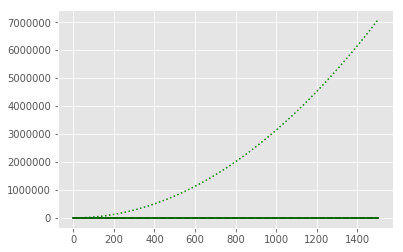

In [29]:
#now to plot and have a look
r = np.linspace(0, 1500, 100)
plt.plot(r, Kest.poisson(r), color='green', ls=':', label=r'$K_{pois}$')
plt.plot(r, Kest(data=regLocsAsArray, radii=r, mode='none'), color='red', ls='--',
         label=r'$K_{un}$')
plt.plot(r, Kest(data=regLocsAsArray, radii=r, mode='translation'), color='black',
         label=r'$K_{trans}$')
plt.plot(r, Kest(data=regLocsAsArray, radii=r, mode='ohser'), color='blue', ls='-.',
         label=r'$K_{ohser}$')
plt.plot(r, Kest(data=regLocsAsArray, radii=r, mode='var-width'), color='green',
         label=r'$K_{var-width}$')
plt.plot(r, Kest(data=regLocsAsArray, radii=r, mode='ripley'), color='yellow',
         label=r'$K_{ripley}$')

In [ ]:
#try out a dbscan of all reggae
#create new dbscan cluster object
dbscan = DBSCAN(eps=500, min_samples=3)

In [ ]:
#get only locations from the reggae set
#get just locations
#use the locsArray again

dbscan1stRun = dbscan.fit(locsAsArray)

In [ ]:
#get the labels of the groups
dbscan_labels = dbscan.labels_

In [ ]:
dbscan_labels

In [ ]:
#now add the labels back into the reggae dataframe
#need to reindex allReggaeEvents for it to work
#londonEventsdfNoNan = londonEventsdfNoNan.reset_index()

In [ ]:
londonEventsdfNoNan['dbscanLabels1'] = pd.DataFrame(dbscan_labels)

In [ ]:
#now give it a plot
#define colorscheme

londonEventsdfNoNan.plot.scatter(y='lng', x='lat', c='dbscanLabels1', )

In [ ]:
#try clustering out on the whole dataset
dbscan2ndRun = dbscan.fit(locsAsArray)

In [ ]:
londonEventsdf